# Investigating Computational Redundancy in CNNs Using Knowledge Distillation
Deep Learning Tutorial Final Project - Professor Sterne
--
In this assignment, I will investigate the performance of three Convolutional Neural Networks (CNNs), which are all variants of a baseline CNN, using two different training regimes (regular and knowledge distillation). The purpose of this assignment is to see how important depth and width are in CNNs, as well as investigate the efficacy of knowledge distillation. Finally, results are shown for each CNN - number of parameters and inference time, and for both training regimes - training time and final accuracy score.

## Introduction & Motivation
In this assignment, I am investigating both CNN structure and the efficacy of knowledge distillation.

I have decided to investigate CNN structure because papers about popular and well-established CNNs seem full of "magic" layer numbers and hyperparameters, and so I wanted to see for myself whether I can get a feel for how changing these values affects the performance of the model. I have chosen to train and evaluate my models on CIFAR10, since I have already worked with it before and its small size allows for fast prototyping (I did not want to leverage any pretrained models and so I had to train from scratch). However, that also means that it is much easier for a large network to memorize it (as 50,000 images of 32x32 pixels is roughly 50 million numbers) or to contain computational redundancies, where some of the parameters of the model are not vital in order for it to perform well.

In addition to that, I have recently seen some impressive results based using "depthwise separable convolutions", which have been developed and explored mostly in papers investigating the performance of CNNs in the mobile devices setting such as Howard et al. (2017). The main idea is that a regular convolutional layer can be replaced by two much smaller convolutional layers, one working depthwise (across channels) and one working pointwise (across a feature map), and thus achieving high performance with a fraction of the parameters. Since this seems like a powerful idea that can be used in a variety of settings in order to reduce the size of a CNN, I have decided to investigate it as well. I have decided to implement these as having rectangular kernels in order to see whether solely stacking these two layers after each other makes up for the lower parameter count, and so I will refer to my implementation as "depthwise-pointwise convolution".

Therefore I knew I would like to investigate the number of layers (model depth), the size of the layers (model width), and the structure of the convolutional block itself, so I have chosen a classic CNN that is easy to work with - VGG. Since I knew I will be comparing smaller variants (in terms of parameters) to a baseline, I decided I may as well also investigate another interesting topic at the same time - knowledge distillation. Knowledge distillation quickly rose to prominence after Hinton et al. (2015) have shown that a smaller model can perform much better when trained on the predictions of a larger (trained) model than when trained directly on the labels of tha data itself.

In conclusion, I have chosen to investigate how smaller variants of a VGG-like network perform on the CIFAR10 image classification problem under both a standard training regime and a knowledge distillation training regime.

In [1]:
#imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from torchvision import datasets, transforms
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
import time

In [0]:
#preprocessing using per-channel mean and std, calculated from data
#same procedure as last assignment so not shown again
stats = ([0.474, 0.473, 0.473], [0.252, 0.252, 0.251])
#transforms are standard
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(*stats)]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(*stats)]),
}

#small images so large batch size
bs = 128

#setting up dataloaders and device, same as before
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=data_transforms['train'])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=4)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=data_transforms['val'])
testloader = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=4)

dataloaders = {
    "train": trainloader,
    "val": testloader
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Files already downloaded and verified
Files already downloaded and verified
cuda:0


## Helper Functions
In addition to measuring training time for each CNN variant, I also wanted to measure inference time (on the GPU), for example because depthwise-pointwise convolutions replace each convolutional layer in the original model with 2 new (much smaller) convolutional layers, and so I wanted to see how the lower parameter count versus the increased depth affect the performance of the trained model at inference time. Calculating inference time in Pytorch is fairly straightforward - simply creating some input of the right size and running it through the model some large number of times in order to get reliable estimates of the time it takes. The two important points are to set the model in eval mode and turn off gradient calculations, in order to simulate using the model for inference only, and to ask cuda to synchronize - meaning to finish all current tasks - so that the time calculated accurately captures all required GPU operations.

The training function is similar to the one from the CV assignment - however it has been slightly modified in order to optionally leverage knowledge distillation if a teacher model is passed. In that case, the model which is currently training will receive the logits from the teacher model as labels instead of the actual labels from the data, and therefore it is also expected to be using numeric loss such as Mean Squared Error (MSE) instead of categorical loss such as Cross Entropy. The idea behind using the teacher's logits is that they represent an unnormalized probability distribution over the possible classes, which usually gets squished into one big number and many tiny numbers after being put through a softmax, and therefore the logits themselves are much more informative in order for the smaller model to learn to emulate the larger teacher model.

In [0]:
def calculate_inference_time(model, it=1000):
    times = []
    inp = torch.randn(1, 3, 32, 32).cuda()
    model = model.cuda()
    model.eval()
    for i in range(it):
        start = time.time()
        with torch.no_grad():
            outp = model(inp)
        
        torch.cuda.synchronize()
        end = time.time()
        times.append(end-start)
    
    return np.mean(times) * 1000, np.std(times) * 1000

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, teacher=None):
    '''
    This function takes in a model, a loss function,
    an optimizer, a learning-rate scheduler, and
    a number of epochs, and runs the train loop
    while plotting live training results.
    Returns best model at the end of training.
    Slightly modified from liveloss example.
    '''
    liveloss = PlotLosses()
    model = model.to(device)
    #if using knowledge distillation, move teacher to GPU and set to eval
    if teacher: 
        teacher = teacher.to(device)
        teacher.eval()
    since = time.time()

    best_acc = 0.0

    for epoch in range(num_epochs):
        logs = {}
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                #load data and labels
                inputs = inputs.to(device)
                labels = labels.to(device)
    
                #run data through model
                outputs = model(inputs)

                #if using kd - get teacher logits for loss
                if teacher:
                    with torch.no_grad():
                        logits = teacher(inputs)
                    loss = criterion(outputs, logits)
                    
                #otherwise - use real labels for loss
                else:
                    loss = criterion(outputs, labels)

                if phase == 'train':

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'val':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
            
        scheduler.step()
        
        liveloss.update(logs)
        liveloss.draw()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

## Base Model - VGG13bn
I have chosen the VGG13bn variant (which can be seen [here](https://pytorch.org/docs/stable/_modules/torchvision/models/vgg.html), under configuration B) to be my baseline model, as it contains 2 equal-sized convolutional layers at every feature map size, and so it is sizeable but also easy to experiment with. I have chosen to add batchnorm after every layer and remove maxpool layers and instead use stride-2 convolutions, as is popular these days, and have also slightly modified the dimensionality reduction scheme in order to fit our 32x32 input images. All in all, the network contains 10 convolutional layers followed by 3 fully-connected layers with dropout.

As we can see below, this model contains about 10 million parameters, reaches ~89% accuracy in about 40 epochs, and takes about 1.8 ms to perform inference on a single example. I will repeat these measurements for all experiments.

In [2]:
class ConvBlock(nn.Module):
    '''
    Standard convolutional block -
    convolutional layer followed by a batchnorm and a relu.
    '''

    def __init__(self, inp, outp, k, s, p):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(inp, outp, k, s, p)
        self.bn = nn.BatchNorm2d(outp)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.act(x)
        x = self.bn(x)
        return x

    

p = 0.6 #fixed dropout for all models
def create_net1():
    '''
    VGG13bn-style network.
    '''
    net1 = nn.Sequential(ConvBlock(3, 64, 7, 1, 3),
                        ConvBlock(64, 64, 3, 1, 1),
                        ConvBlock(64, 128, 3, 2, 1),
                        ConvBlock(128, 128, 3, 1, 1),
                        ConvBlock(128, 256, 3, 1, 1),
                        ConvBlock(256, 256, 3, 2, 1),
                        ConvBlock(256, 512, 3, 1, 1),
                        ConvBlock(512, 512, 3, 2, 1),
                        ConvBlock(512, 512, 3, 1, 1),
                        ConvBlock(512, 512, 3, 2, 1),
                        nn.Flatten(),
                        nn.Linear(2048, 512),
                        nn.ReLU(),
                        nn.BatchNorm1d(512),
                        nn.Dropout(p),
                        nn.Linear(512, 128),
                        nn.ReLU(),
                        nn.BatchNorm1d(128),
                        nn.Dropout(p),
                        nn.Linear(128, 10)
                        )
    return net1

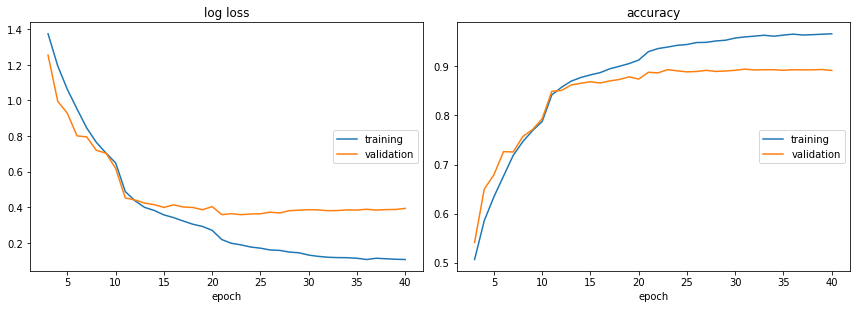

log loss:
training   (min:    0.106, max:    1.849, cur:    0.106)
validation (min:    0.358, max:    1.706, cur:    0.393)

accuracy:
training   (min:    0.306, max:    0.967, cur:    0.967)
validation (min:    0.380, max:    0.894, cur:    0.892)
Training complete in 28m 7s
(1.8683998584747314, 0.1428404761249531)


In [0]:
n_epochs=40 #40 epochs for all models
net1 = create_net1()
criterion = nn.CrossEntropyLoss()
#adam with weight decay optimizer with 5e-3 lr for all models
optimizer = optim.AdamW(net1.parameters(), lr=5e-3)
#lr scheduler for all models - multiply by 0.2 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)
train_model(net1, criterion, optimizer, exp_lr_scheduler, num_epochs=n_epochs)
print(calculate_inference_time(net1))

In [3]:
#calculate number of trainable parameters - used for all models
print(sum(p.numel() for p in net1.parameters() if p.requires_grad))

10535882


## Experimental Setup
I will conduct six experiments in total, which include two training regimes for three different CNN variants.
* 'net1' will refer to the baseline model as shown above.
* 'net2' will refer to the narrower variant - the same number of layers as the baseline, but with half the number of filters for the convolutional layers (and slightly changed input to linear layer as a result).
* 'net3' will refer to the shallower variant - only 1 convolutional layer at every feature map size instead of 2 as in the baseline, with the same number of filters as before.
* 'net4' will refer to the depthwise-pointwise variant. Each convolutional layer is replaced by two stacked convolutional layers. The first one is depthwise, meaning that there is only a single kernel for all the input channels for each filter (instead of a kernel per channel), and so this layer has 1xkxkxf number of parameters overall instead of cxkxkxf, where c refers to the input channels, k refers to the (rectangular) filter size, and f refers to the number of filters. The second one is pointwise, meaning that there is only a single parameter (1x1 kernel) sliding over each feature map for each filter, and so this layer has cx1x1xf number of parameters overall instead of cxkxkxf, where c refers to the input channels, k refers to the (rectangular) filter size, and f refers to the number of filters. These two layers (together with the added batchnorm) have dramatically less parameters than the original full convolutional layer, but they also add depth to the network, and so I am curious to see how performance changes and whether training and inference are actually any faster.

All three variants will be trained twice, once with cross-entropy loss with the data labels (usual training process) and once with knowledge distillation - with MSE loss using the baseline model's logits. In the paper they recommend using a temperature in order to obtain a soft normalized probability distribution, but it is a hyperparameter which requires tweaking (the paper mentions different values work best for different problems) and is also tricky to implement as Pytorch calculates the softmax implicitly, and so I directly use the logits which is a special case as mentioned in the paper.

All experiments will be conducted using the same linear layers (only convolutional backbone is modified), the same regularization (such as dropout), the same optimizer, the same learning rate, the same schedule, and the same number of epochs - in other words, all other variables will be held constant in order to conduct these experiments in an unbiased manner.

## Hypotheses
Overall, I expected all three variants to perform about 5% worse than the baseline model as they are 2x-4x smaller but the baseline model may be somewhat computationally redundant for this small task. I also expected the knowledge distillation training to perform better than regular training as was mentioned in the paper, perhaps in the middle between the two so 2.5% worse than the baseline model but 2.5% better than training on the data. I also expected training and inference times to be linearly proportional to the number of parameters of the model.

In [4]:
def create_net2():
    '''
    Similar to net1, but with half the filters.
    '''
    net2 = nn.Sequential(ConvBlock(3, 32, 7, 1, 3),
                        ConvBlock(32, 32, 3, 1, 1),
                        ConvBlock(32, 64, 3, 2, 1),
                        ConvBlock(64, 64, 3, 1, 1),
                        ConvBlock(64, 128, 3, 1, 1),
                        ConvBlock(128, 128, 3, 2, 1),
                        ConvBlock(128, 256, 3, 1, 1),
                        ConvBlock(256, 256, 3, 2, 1),
                        ConvBlock(256, 256, 3, 1, 1),
                        ConvBlock(256, 256, 3, 2, 1),
                        nn.Flatten(),
                        nn.Linear(1024, 512),
                        nn.ReLU(),
                        nn.BatchNorm1d(512),
                        nn.Dropout(p),
                        nn.Linear(512, 128),
                        nn.ReLU(),
                        nn.BatchNorm1d(128),
                        nn.Dropout(p),
                        nn.Linear(128, 10)
                        )
    return net2

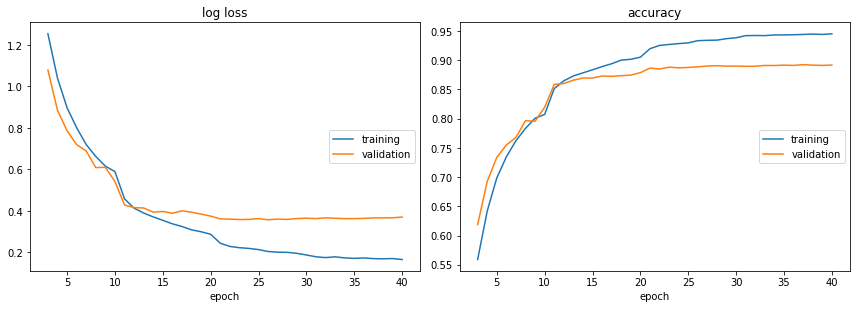

log loss:
training   (min:    0.166, max:    1.823, cur:    0.166)
validation (min:    0.358, max:    1.540, cur:    0.371)

accuracy:
training   (min:    0.319, max:    0.945, cur:    0.945)
validation (min:    0.422, max:    0.892, cur:    0.892)
Training complete in 9m 60s
(1.3283300399780273, 0.1784923069940297)


In [0]:
net2 = create_net2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net2.parameters(), lr=5e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)
train_model(net2, criterion, optimizer, exp_lr_scheduler, num_epochs=n_epochs)
print(calculate_inference_time(net2))

In [5]:
print(sum(p.numel() for p in net2.parameters() if p.requires_grad))

2952234


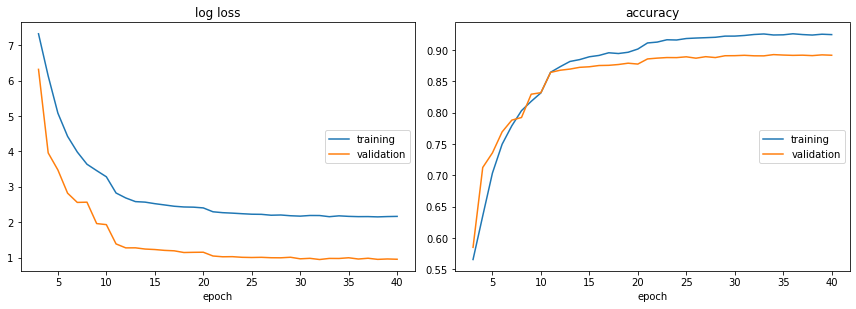

log loss:
training   (min:    2.150, max:   10.958, cur:    2.164)
validation (min:    0.945, max:    9.269, cur:    0.952)

accuracy:
training   (min:    0.347, max:    0.926, cur:    0.925)
validation (min:    0.442, max:    0.893, cur:    0.892)
Training complete in 15m 46s
(1.341912031173706, 0.2986450977188439)


In [0]:
net2 = create_net2()
#notice the MSE loss for the knowledge distillation training
criterion = nn.MSELoss()
optimizer = optim.AdamW(net2.parameters(), lr=5e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)
train_model(net2, criterion, optimizer, exp_lr_scheduler, n_epochs, net1)
print(calculate_inference_time(net2))

In [6]:
def create_net3():
    '''
    Similar to net1, but with half the conv layers.
    '''
    net3 = nn.Sequential(ConvBlock(3, 64, 7, 1, 3),
                        ConvBlock(64, 128, 3, 2, 1),
                        ConvBlock(128, 256, 3, 2, 1),
                        ConvBlock(256, 512, 3, 2, 1),
                        ConvBlock(512, 512, 3, 2, 1),
                        nn.Flatten(),
                        nn.Linear(2048, 512),
                        nn.ReLU(),
                        nn.BatchNorm1d(512),
                        nn.Dropout(p),
                        nn.Linear(512, 128),
                        nn.ReLU(),
                        nn.BatchNorm1d(128),
                        nn.Dropout(p),
                        nn.Linear(128, 10)
                        )
    return net3

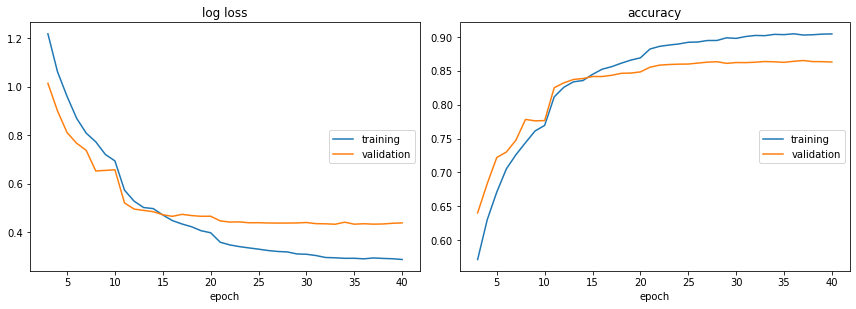

log loss:
training   (min:    0.288, max:    1.757, cur:    0.288)
validation (min:    0.433, max:    1.471, cur:    0.439)

accuracy:
training   (min:    0.350, max:    0.905, cur:    0.904)
validation (min:    0.465, max:    0.865, cur:    0.863)
Training complete in 14m 43s
(0.9413914680480957, 0.15212353847875282)


In [0]:
net3 = create_net3()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net3.parameters(), lr=5e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)
train_model(net3, criterion, optimizer, exp_lr_scheduler, num_epochs=n_epochs)
print(calculate_inference_time(net3))

In [8]:
print(sum(p.numel() for p in net3.parameters() if p.requires_grad))

5038730


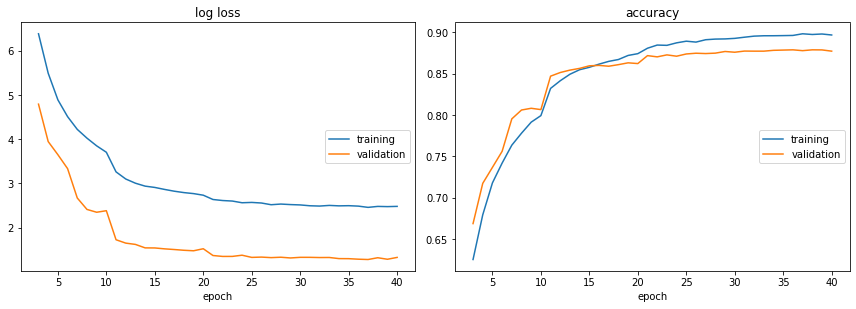

log loss:
training   (min:    2.459, max:   10.475, cur:    2.481)
validation (min:    1.279, max:    7.900, cur:    1.327)

accuracy:
training   (min:    0.384, max:    0.898, cur:    0.897)
validation (min:    0.498, max:    0.879, cur:    0.877)
Training complete in 20m 38s
(0.9457268714904785, 0.1222936294771204)


In [0]:
net3 = create_net3()
criterion = nn.MSELoss()
optimizer = optim.AdamW(net3.parameters(), lr=5e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)
train_model(net3, criterion, optimizer, exp_lr_scheduler, n_epochs, net1)
print(calculate_inference_time(net3))

In [9]:
class DepthwisePointwiseConv(nn.Module):
    '''
    A depthwise-pointwise convolutional block -
    consisting of a depthwise convolution
    followed by a batchnorm and a relu and then
    a pointwise convolution.
    See full explanation above.
    '''

    def __init__(self, inp, outp, k, s, p):
        super(DepthwisePointwiseConv, self).__init__()
        self.depthwise = nn.Conv2d(inp, inp, kernel_size=k, stride=s, padding=p, groups=inp)
        self.bn1 = nn.BatchNorm2d(inp)
        self.pointwise = nn.Conv2d(inp, outp, kernel_size=1)
        self.bn2 = nn.BatchNorm2d(outp)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.depthwise(x)
        x = self.bn1(self.act(x))
        x = self.pointwise(x)
        x = self.bn2(self.act(x))
        return x

def create_net4():
    '''
    Same as net1, but with new block.
    '''
    net = nn.Sequential(DepthwisePointwiseConv(3, 64, 7, 1, 3),
                        DepthwisePointwiseConv(64, 64, 3, 1, 1),
                        DepthwisePointwiseConv(64, 128, 3, 2, 1),
                        DepthwisePointwiseConv(128, 128, 3, 1, 1),
                        DepthwisePointwiseConv(128, 256, 3, 1, 1),
                        DepthwisePointwiseConv(256, 256, 3, 2, 1),
                        DepthwisePointwiseConv(256, 512, 3, 1, 1),
                        DepthwisePointwiseConv(512, 512, 3, 2, 1),
                        DepthwisePointwiseConv(512, 512, 3, 1, 1),
                        DepthwisePointwiseConv(512, 512, 3, 2, 1),
                        nn.Flatten(),
                        nn.Dropout(p),
                        nn.Linear(2048, 512),
                        nn.ReLU(),
                        nn.BatchNorm1d(512),
                        nn.Dropout(p),
                        nn.Linear(512, 128),
                        nn.ReLU(),
                        nn.BatchNorm1d(128),
                        nn.Dropout(p),
                        nn.Linear(128, 10)
                        )
    return net

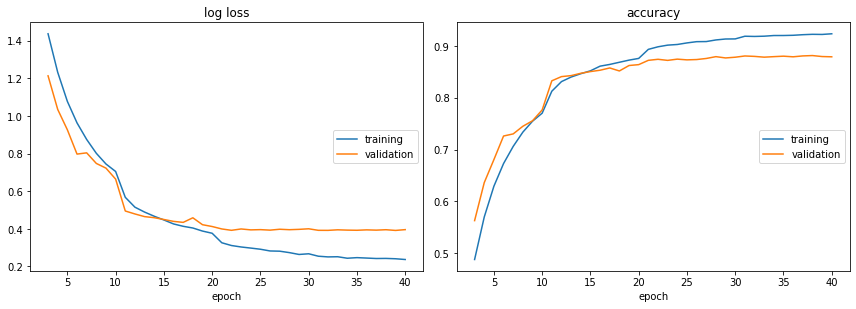

log loss:
training   (min:    0.237, max:    1.915, cur:    0.237)
validation (min:    0.391, max:    1.606, cur:    0.396)

accuracy:
training   (min:    0.280, max:    0.923, cur:    0.923)
validation (min:    0.390, max:    0.881, cur:    0.879)
Training complete in 14m 6s
(1.9795150756835938, 0.27669855679358446)


In [0]:
net4 = create_net4()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net4.parameters(), lr=5e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)
train_model(net4, criterion, optimizer, exp_lr_scheduler, num_epochs=n_epochs)
print(calculate_inference_time(net4))

In [10]:
net4 = create_net4()
print(sum(p.numel() for p in net4.parameters() if p.requires_grad))

2200166


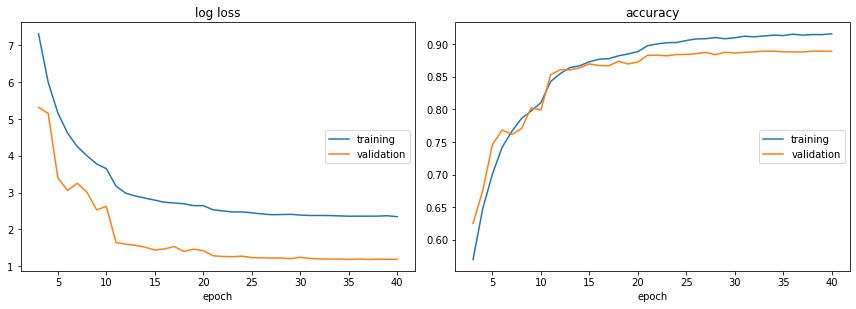

log loss:
training   (min:    2.346, max:   11.667, cur:    2.346)
validation (min:    1.186, max:    9.204, cur:    1.191)

accuracy:
training   (min:    0.312, max:    0.916, cur:    0.916)
validation (min:    0.438, max:    0.889, cur:    0.889)
Training complete in 20m 11s
(1.9693832397460935, 0.28148841870349584)


In [0]:
net4 = create_net4()
criterion = nn.MSELoss()
optimizer = optim.AdamW(net4.parameters(), lr=5e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)
train_model(net4, criterion, optimizer, exp_lr_scheduler, n_epochs, net1)
print(calculate_inference_time(net4))

## Results
|      | #_of_parameters | train_time_labels | accuracy | train_time_kd | accuracy_kd | inference_time_mean | inference_time_std |
|------|-----------------|-------------------|----------|---------------|-------------|---------------------|--------------------|
| net1 | 10.5m           | 28m 7s            | **89.4%**    | -             | -           | 1.87ms              | 0.14ms             |
| net2 | 2.95m           | **9m 60s**            | 89.2%    | **15m 46s**       | **89.3%**       | 1.34ms              | 0.3ms              |
| net3 | 5.03m           | 14m 43s           | 86.5%    | 20m 38s       | 87.9%       | **0.95ms**              | 0.12ms             |
| net4 | **2.2m**            | 14m 6s            | 88.1%    | 20m 11s       | 88.9%       | 1.97ms              | 0.28ms             |


As we can see, the narrow variant net2 seems to be the overall winner - it contains less than a third of the parameters, trains three times faster, performs inference about 30% faster and yet achieves the same accuracy as the baseline model, suggesting that our original hypothesis that the baseline model is overkill for our problem and contains a lot of computational redundancy is correct. 

Knowledge distillation seems to be a very interesting technique - even in its naive form of simply training on the logits of the teacher, it seems to improve performance for all three variants (at the cost of more training time).

It is interesting to me that net3 took longer to train even though it is shallower - probably because it contains significantly more parameters.

It is also interesting for me to see that accuracy is not linearly correlated with number of parameters as I had implicitly assumed many times before - a deep, narrow model seems to contain less parameters and perform better in this case.

Net4 is overall a disappointment for me - although it contains the least parameters and performs almost as well as the baseline model, it takes longer to train than net2 and actually performs inference the slowest of all the models. This suggests to me that inference is strongly correlated with the depth of the model, which is supported by the fact that net3 is the fastest even though it has many more parameters than net2 or net4. The sole advantage of net4 seems to be the minimal number of parameters and therefore the smallest amount of memory required to load the network - however, I suspect that it is possible to trim net2 some more and achieve comparable accuracy to net4 with better training and inference times.

Note: Accuracy here is taken to be the maximum validation accuracy achieved by the model over 40 epochs, and inference time shown here is the mean in 1,000 runs - standard deviations are also shown in order to highlight the stability of the results.

## References
* Hinton, G., Vinyals, O., & Dean, J. (2015). Distilling the knowledge in a neural network. arXiv preprint arXiv:1503.02531.
* Howard, A. G., Zhu, M., Chen, B., Kalenichenko, D., Wang, W., Weyand, T., ... & Adam, H. (2017). Mobilenets: Efficient convolutional neural networks for mobile vision applications. arXiv preprint arXiv:1704.04861.